In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [5]:
torch.manual_seed(42)

class Net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, 2)
        self.tanh = nn.Tanh() 

    def forward(self, x, A):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)

        return out 
    
hidden_size = 50
model = Net(hidden_size)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)


def func_x(t, C2, w, A, B):
    return C2*torch.cos(w*t - (np.pi/2)) + A*t + B

def func_theta(t, C1, w):
    return C1*torch.cos(w*t - (np.pi/2))


def func_dx(t, w, C2, A):
    return -C2*w*torch.sin(w*t - (np.pi/2)) + A

def func_dtheta(t, w, C1):
    return -C1*w*torch.sin(w*t - (np.pi/2))

def error(f, fp):
    return torch.mean((f - fp)**2)



def loss_fn(theta, d2theta, d2x, x0, x0p, dx0, dx0p, theta0, theta0p, dtheta0, dtheta0p, M, m, l, g):

    interior1 = (M + m)*d2x + (m*l)*d2theta
    interior2 = d2x + l*d2theta + g*theta
    
    boundry1 =  x0 - x0p
    dboundry1 = dx0 - dx0p
    
    boundry2 =  theta0 - theta0p
    dboundry2 = dtheta0 - dtheta0p

    loss = torch.mean((interior1)**2) + torch.mean((interior2)**2)
    loss_b1 = torch.mean((boundry1)**2) + torch.mean((dboundry1)**2)
    loss_b2 = torch.mean((boundry2)**2) + torch.mean((dboundry2)**2)

    loss_value = loss + loss_b1 + loss_b2

    return loss_value

iteration 1/20, loss = 1.4134536981582642 tensor(0.2275, grad_fn=<MeanBackward0>) tensor(0.0420, grad_fn=<MeanBackward0>)
iteration 2/20, loss = 0.8824948072433472 tensor(0.0614, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
iteration 3/20, loss = 0.07223738729953766 tensor(0.0189, grad_fn=<MeanBackward0>) tensor(0.0145, grad_fn=<MeanBackward0>)
iteration 4/20, loss = 0.05309376120567322 tensor(0.0074, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
iteration 5/20, loss = 0.0031347526237368584 tensor(0.0008, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
iteration 6/20, loss = 0.0005423665279522538 tensor(1.5903e-05, grad_fn=<MeanBackward0>) tensor(1.0908e-05, grad_fn=<MeanBackward0>)
iteration 7/20, loss = 0.00038369567482732236 tensor(4.5335e-05, grad_fn=<MeanBackward0>) tensor(4.5653e-05, grad_fn=<MeanBackward0>)
iteration 8/20, loss = 0.007694258354604244 tensor(0.0009, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackwa

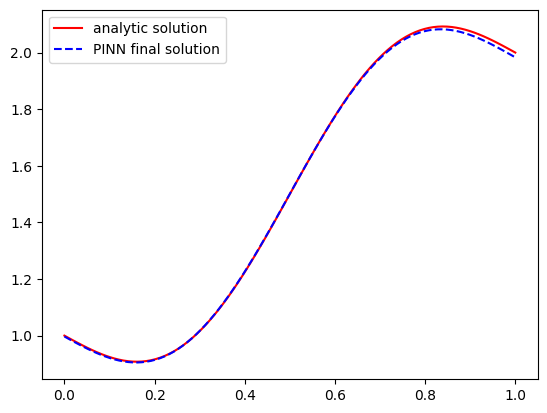

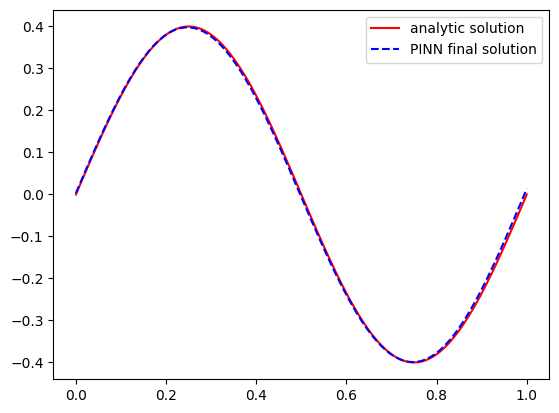

In [7]:
torch.manual_seed(42)
domain = (0, 1)
batches = 80
batch_size = 10

M , l, g = 1, 1, 10
m = ((((2*np.pi)**2)*M)/((1)*(g/l))) - M
A, B = 1, 1
C1 = 0.4
C2 = -((C1*m*l) / (m+M))
w = ((1 + (m/M))**(0.5))*((g/l)**(0.5))


t = torch.linspace(domain[0], domain[1], batches)
t.requires_grad = True
t = t.view(t.shape[0], 1)
loader = DataLoader(t, batch_size,shuffle=True)

t0 = torch.tensor([0.0])
t0 = t0.view(t0.shape[0], 1)
t0.requires_grad = True

x0 = func_x(t0, C2, w, A, B)
x0 = x0.view(x0.shape[0], 1)
dx0 = torch.tensor([func_dx(t0, w, C2, A)])
dx0 = dx0.view(dx0.shape[0], 1)



theta0 = func_theta(t0, C1, w)
theta0 = theta0.view(theta0.shape[0], 1)
dtheta0 = torch.tensor([func_dtheta(t0, w, C1)])
dtheta0 = dtheta0.view(dtheta0.shape[0], 1)


epochs = 20
for epoch in range(epochs):
    # print(epoch)
    for t in loader:
        for j in range(30):
            
            data = model(t, A)
            
            x = data[:, 0]
            x = x.view(x.shape[0], 1)
            
            theta = data[:, 1]
            theta = theta.view(theta.shape[0], 1)
            
            dx = grad(x, t)[0]
            d2x = grad(dx, t)[0]
            
            dtheta = grad(theta, t)[0]
            d2theta = grad(dtheta, t)[0]
            
            data0p = model(t0, A)
            
            x0p = data0p[:, 0]
            x0p = x0p.view(x0p.shape[0], 1)
            
            theta0p = data0p[:, 1]
            theta0p = theta0p.view(theta0p.shape[0], 1)
            
            dx0p = grad(x0p, t0)[0]
            
            dtheta0p = grad(theta0p, t0)[0]
            
            
            loss = loss_fn(theta, d2theta, d2x, x0, x0p, dx0, dx0p, theta0, theta0p, dtheta0, dtheta0p, M, m, l, g)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

    if (epoch+1) % 1 == 0:
        print(f'iteration {epoch+1}/{epochs}, loss = {loss}',error(func_x(t, C2, w, A, B), x), error(func_theta(t, C1, w), theta))
    
    
t_p = torch.linspace(domain[0], domain[1],100)
t_p = t_p.view(t_p.shape[0], 1)

prediction = model(t_p, A)

x_predic = prediction[:, 0]
x_predic = x_predic.view(x_predic.shape[0], 1)
theta_predic = prediction[:, 1]
theta_predic = theta_predic.view(theta_predic.shape[0], 1)

analytical_x = func_x(t_p, C2, w, A, B)
analytical_theta = func_theta(t_p, C1, w)

fig, ax = plt.subplots()
ax.plot(t_p.detach().numpy(), analytical_x, "r-",label='analytic solution')
ax.plot(t_p.detach().numpy(), x_predic.detach().numpy(), "b--", label='PINN final solution')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(t_p.detach().numpy(), analytical_theta, "r-",label='analytic solution')
ax.plot(t_p.detach().numpy(), theta_predic.detach().numpy(), "b--", label='PINN final solution')
ax.legend()
plt.show()